In [56]:
import numpy as np
import pandas as pd
import thinkstats2
import thinkplot

import seaborn as sns
import matplotlib.pyplot as mth
import statsmodels.formula.api as smf

In [57]:
data = pd.read_csv('crime.csv', encoding='latin1')
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


In [58]:
cdf = thinkstats2.Cdf(data.MONTH, label='cdf')

In [59]:
import survival

def MakeSurvivalFromCdf(cdf, label=''):
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [60]:
sf = MakeSurvivalFromCdf(cdf, label='survival')

In [61]:
print(cdf[1])
print(sf[1])

0.07399560602119264
0.9260043939788074


All crimes that had happened in january have a probability of 7%, and eventually the survival function for it is 93%.

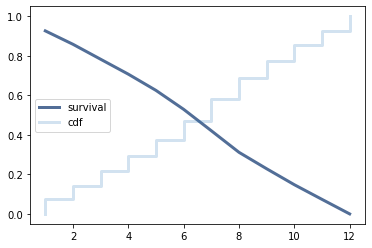

In [62]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc='center left')

The plot above is the cdf and survival curve for months of the crimes.

In [63]:
hf = sf.MakeHazardFunction(label='hazard')
print(hf[5])

0.11614164501857448


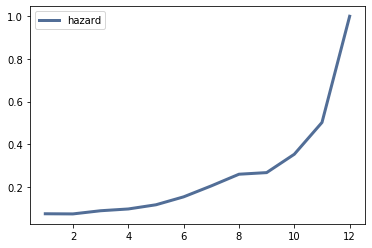

In [64]:
thinkplot.Plot(hf)
thinkplot.Config(loc='upper left')

Here's the hazard curve: the horizontal axis shows the time to event, and the vertical axis shows the cumulative hazard.



# Year of the crime


In [68]:
data.SHOOTING.replace('NaN', 0)
data.SHOOTING.replace('Y', 1)

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
319043    0
319044    0
319045    0
319046    0
319047    0
319048    0
319049    0
319050    0
319051    0
319052    0
319053    0
319054    0
319055    0
319056    0
319057    0
319058    0
319059    0
319060    0
319061    0
319062    0
319063    0
319064    0
319065    0
319066    0
319067    0
319068    0
319069    0
319070    0
319071    0
319072    0
Name: SHOOTING, Length: 319073, dtype: int64

In [69]:
noshot = data[data.SHOOTING == 0].MONTH
shot = data[data.SHOOTING == 1].MONTH

In [71]:

from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):

    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

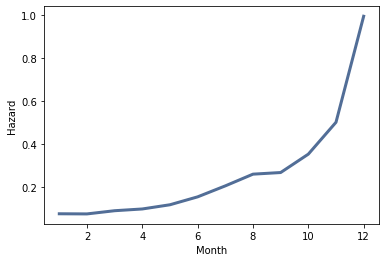

In [72]:
hf = EstimateHazardFunction(noshot, shot)
thinkplot.Plot(hf)
thinkplot.Config(xlabel='Month',
                 ylabel='Hazard')

In here we've computed Kaplan-Meier estimation, which is known for estimation the hazard function, then converting the hazard function to a survival curve.

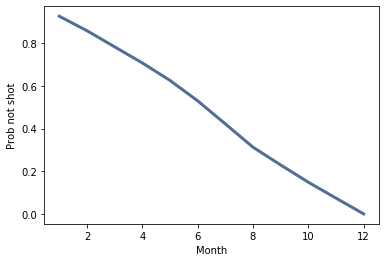

In [73]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel='Month',
                 ylabel='Prob not shot')

Every month has the same probability that the crime would not be commited with a firearm.

## Quantifying uncertainty

To see how much the results depend on random sampling, we'll use a resampling process again.

In [75]:
def EstimateMarriageSurvival(data):

    noshot = data[data.SHOOTING == 0].MONTH
    shot = data[data.SHOOTING == 1].MONTH

    hf = EstimateHazardFunction(noshot, shot)
    sf = hf.MakeSurvival()

    return hf, sf

In [78]:
def ResampleSurvival(data, iters=101):
    _, sf = EstimateMarriageSurvival(data)
    thinkplot.Plot(sf)

    low, high = 1, 12
    ts = np.arange(low, high, 1)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRows(data)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color='gray', label='90% CI')

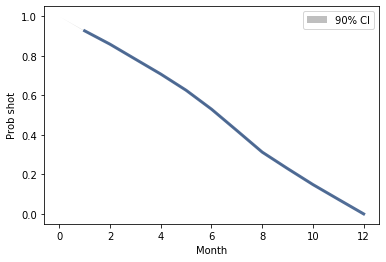

In [77]:
ResampleSurvival(data)
thinkplot.Config(xlabel='Month',
                 ylabel='Prob shot',
                 loc='upper right')

The above plot shows the survival function 90% of confidence interval based on resampling.

In [88]:
data_first_two_years = data[data.YEAR < 2017]
data_next_two_years = data[data.YEAR >= 2017]

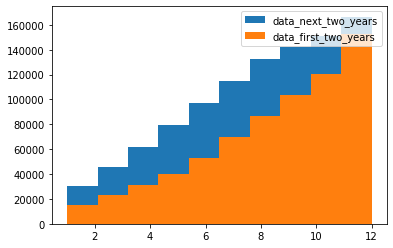

In [91]:
mth.hist(data_next_two_years.MONTH, cumulative=True, label='data_next_two_years')
mth.hist(data_first_two_years.MONTH, cumulative=True, label='data_first_two_years')
mth.legend(loc='upper right')
mth.show()

In [95]:
noshot = data[data.SHOOTING == 0].MONTH
print('Number of crimes without shooting in 2 years in 2017-2018', len(noshot))
shot = data[data.SHOOTING == 1].MONTH
print('Number of crimes with shooting in 2 years in 2017-2018', len(shot))

hf = EstimateHazardFunction(noshot, shot)
sf1 = hf.MakeSurvival()

Number of people without shooting in 2 years in 2017-2018 318054
Number of people with shooting in 2 years in 2017-2018 1019


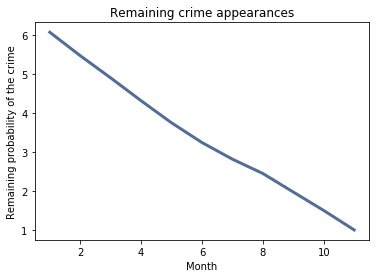

In [96]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(title='Remaining crime appearances',
                 xlabel='Month',
                 ylabel='Remaining probability of the crime')

Now we can see that the crimes happen regardless of the month of the year, and that the shootings without the usage of firearms had happed a lot more often that with them.